In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Case Study 1

#### Model selection for Clustering

Clustering is unsupervised learning: the resulting clusters are completely derived from data distributed in given a feature set with no class available

Compared to supervised learning counterparts, it is …
* hard to define model performance (cluster quality)
* sensitive to different clustering algorithms and different feature spaces.



#### Task
Your task is to try different clustering algorithms and also a range of the potential parameter(s) which affect the number of clusters including ..

* K-means
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* Gaussian Mixture Model,
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
* Hierarchical Clustering,
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
* Louvain Clustering,
https://scikit-network.readthedocs.io/en/latest/reference/clustering.html#module-sknetwork.clustering

on 5K colorectal patches represented by 4 different representation PathologyGAN, ResNet50, InceptionV3 and VGG16


#### Data and its preprocessing
5,000 non-overlapping image patches from hematoxylin & eosin (H&E) stained histological images of human colorectal cancer (CRC) and normal tissue.
* 4 feature sets, PathologyGAN, ResNet50, InceptionV3 and VGG16, are extracted to represent those 5,000 images different dimensional feature spaces.
* PCA and UMAP were employed to reduce each feature sapce into 100-dimensional vectors

* 9 tissue types are also available which include Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM)


#### Performance Measurement
To assess quality of clustering solutions, several approaches are expected to be done and interpreted which include...
* Silhouette Score for goodness of fit test
* Vmeasure Score for homogeneity and completeness test (tissue type available as ground truth)
* Clusters visualisations

For more information, please have a check...
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


#### Report
Report on your preprocessing pipeline, theory and intuition behinds each algorithm and representation, parameter searching and performance evaluation frameworks. If there is any addiotional process, give evidences/justifications on how it helps.

#### Required Packages

In [ ]:
!pip install h5py==2.10.0
!pip install sklearn
!pip install scikit-network
!pip install pickle-mixin==1.0.2
!pip install matplotlib
!pip install plotly


  Using cached h5py-2.10.0.tar.gz (301 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for h5py
  Running setup.py clean for h5py
Failed to build h5py
ERROR: Could not build wheels for h5py, which is required to install pyproject.toml-based projects


### Prepare Tissue Representations

In [ ]:
import h5py
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import pandas as pd


In [ ]:
pge_path = '/content/drive/MyDrive/ML&AI Class/Case Study 1/colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = '/content/drive/MyDrive/ML&AI Class/Case Study 1/colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = '/content/drive/MyDrive/ML&AI Class/Case Study 1/colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = '/content/drive/MyDrive/ML&AI Class/Case Study 1/colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')



In [ ]:
vgg16_content

<HDF5 file "vgg16_dim_reduced_feature.h5" (mode r)>

In [ ]:
#PCA feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature  = vgg16_content['pca_feature'][...]

In [ ]:
#UMAP feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature  = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature  = vgg16_content['umap_feature'][...]

In [ ]:
#tissue type as available ground-truth: labels
filename_pge  = np.squeeze(pge_content['file_name'])
filename_pge = np.array([str(x) for x in filename_pge])
labels_pge = np.array([x.split('/')[2] for x in filename_pge])

filename_vgg  = np.squeeze(pge_content['file_name'])
filename_vgg = np.array([str(x) for x in filename_vgg])
labels_vgg = np.array([x.split('/')[2] for x in filename_vgg])
print(labels_vgg, labels_pge)

['ADI' 'ADI' 'ADI' ... 'TUM' 'TUM' 'TUM'] ['ADI' 'ADI' 'ADI' ... 'TUM' 'TUM' 'TUM']


###Create indexes, labels and test data for Pathology and VGG16

In [ ]:
import random

In [ ]:
random.seed(0)
selected_index_pge = random.sample(list(np.arange(len(pge_umap_feature))), 200)
selected_index_vgg = random.sample(list(np.arange(len(vgg16_umap_feature))), 200)

In [ ]:
test_data_pge = pge_umap_feature[selected_index_pge]
test_label_pge = labels_pge[selected_index_pge]
test_data_vgg = vgg16_umap_feature[selected_index_vgg]
test_label_vgg = labels_vgg[selected_index_vgg]


### Exploratory Analysis

In [ ]:
import plotly.graph_objects as go
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.model_selection import KFold, train_test_split

In [ ]:
traces_pge = []
for name in np.unique(labels_pge):
    trace_pge = go.Scatter3d(
        x=test_data_pge[test_label_pge==name,0],
        y=test_data_pge[test_label_pge==name,1],
        z=test_data_pge[test_label_pge==name,2],
        mode='markers',
        name=name,
        marker=go.scatter3d.Marker(size=4,opacity=0.8)
    )
    traces_pge.append(trace_pge)


data = go.Data(traces_pge)
layout = go.Layout(
            showlegend=True,
    scene=go.Scene(
                xaxis=go.layout.scene.XAxis(title='PC1'),
                yaxis=go.layout.scene.YAxis(title='PC2'),
                zaxis=go.layout.scene.ZAxis(title='PC3')
                )
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title="First 3 pricipal components of PathologyGAN's PCA feature",
    legend_title="Legend Title",
)

fig.show()


/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:489: DeprecationWarning:

plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene




In [ ]:
traces_vgg = []
for name in np.unique(labels_vgg):
    trace_vgg = go.Scatter3d(
        x=test_data_vgg[test_label_vgg==name,0],
        y=test_data_vgg[test_label_vgg==name,1],
        z=test_data_vgg[test_label_vgg==name,2],
        mode='markers',
        name=name,
        marker=go.scatter3d.Marker(size=4,opacity=0.8)
    )
    traces_vgg.append(trace_vgg)


data = go.Data(traces_vgg)
layout = go.Layout(
            showlegend=True,
    scene=go.Scene(
                xaxis=go.layout.scene.XAxis(title='PC1'),
                yaxis=go.layout.scene.YAxis(title='PC2'),
                zaxis=go.layout.scene.ZAxis(title='PC3')
                )
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title="First 3 pricipal components of VGG16's PCA feature",
    legend_title="Legend Title",
)

fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:489: DeprecationWarning:

plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene




### Model training

In [ ]:
from sklearn.mixture import GaussianMixture
from sknetwork.clustering import Louvain


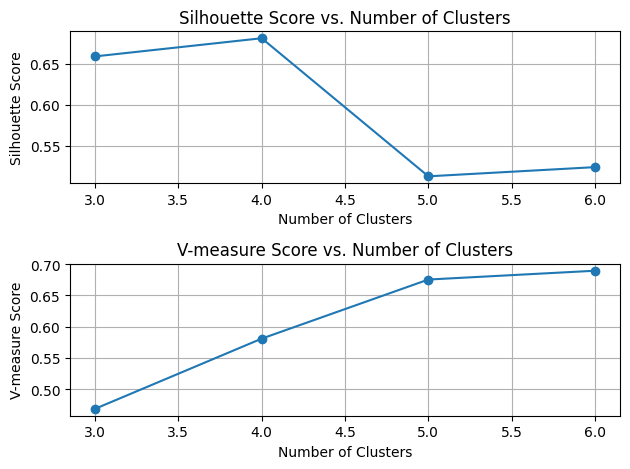

[0.6588965, 0.6809832, 0.513021, 0.5241888]
[0.4684034906902612, 0.5808651092558016, 0.6755430556376719, 0.6896487887802087]


In [ ]:
silhouette_scores = []
v_measure_scores = []
number_of_members=[]
n_clusters_list=list(range(3,7))

for n_clusters in range(3, 7):
  gmm_vgg= GaussianMixture(n_components=n_clusters, random_state=0)
  gmm_vgg.fit(test_data_vgg)  # fit for pca
  gmm_assignment= gmm_vgg.predict(test_data_vgg)  # Use combined_data here if needed

  gmm_silhouette = skm.silhouette_score(test_data_vgg, gmm_assignment)
  silhouette_scores.append(gmm_silhouette)

  gmm_v_measure = skm.v_measure_score(test_label_vgg, gmm_assignment)
  v_measure_scores.append(gmm_v_measure)

  gmm_counts = np.unique(gmm_assignment, return_counts = True)
  number_of_members.append(gmm_counts)
A=pd.DataFrame({
    'Number of Clusters': n_clusters_list,
    'Silhouette Score': silhouette_scores,
    'V-measure Score': v_measure_scores
})

plt.subplot(2, 1, 1)
plt.plot(A['Number of Clusters'], A['Silhouette Score'], marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Stacked bar plot for number of members
plt.subplot(2, 1, 2)
plt.plot(A['Number of Clusters'], A['V-measure Score'], marker='o')
plt.title('V-measure Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('V-measure Score')
plt.grid(True)

plt.tight_layout()
plt.show()
print(silhouette_scores)
print(v_measure_scores)

### Evaluation and Visualisation

* check out number of clusters/cluster assignment counts

In [ ]:
from tabulate import tabulate
df_list = []
for cluster, members in number_of_members:
    df_list.append(pd.DataFrame({'Cluster': cluster, 'Number of Members': members}))

# Display each DataFrame
for i, df in enumerate(df_list, 3):  # Start the index from 3 (as in your provided data)
    print(f"Number of Clusters: {i}")
    print(tabulate(df, headers='keys', tablefmt='grid'))
    print("\n" + "="*30 + "\n")  # Separating each table with a line

Number of Clusters: 3
+----+-----------+---------------------+
|    |   Cluster |   Number of Members |
+====+===========+=====================+
|  0 |         0 |                 152 |
+----+-----------+---------------------+
|  1 |         1 |                  25 |
+----+-----------+---------------------+
|  2 |         2 |                  23 |
+----+-----------+---------------------+


Number of Clusters: 4
+----+-----------+---------------------+
|    |   Cluster |   Number of Members |
+====+===========+=====================+
|  0 |         0 |                 136 |
+----+-----------+---------------------+
|  1 |         1 |                  25 |
+----+-----------+---------------------+
|  2 |         2 |                  23 |
+----+-----------+---------------------+
|  3 |         3 |                  16 |
+----+-----------+---------------------+


Number of Clusters: 5
+----+-----------+---------------------+
|    |   Cluster |   Number of Members |
+====+===========+==========

* Visualise tissue type percentage in two different clustering configurations

In [ ]:
def calculate_percent(sub_df, attrib):
    cnt = sub_df[attrib].count()
    output_sub_df = sub_df.groupby(attrib).count()
    return (output_sub_df/cnt)

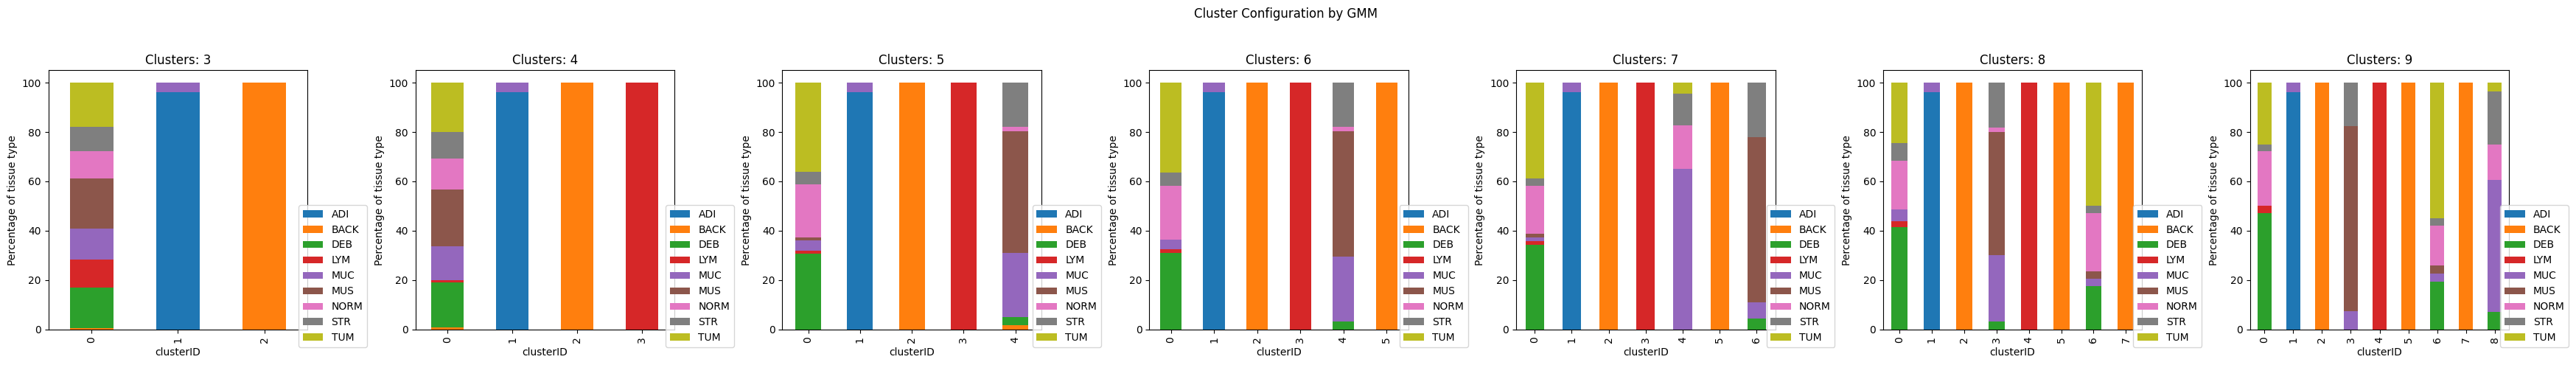

In [ ]:
resulted_cluster_df = pd.DataFrame({'clusterID': gmm_assignment, 'type': test_label_vgg})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')

cluster_range = range(3, 10)
fig, axes = plt.subplots(1,len(cluster_range), figsize=(5 * len(cluster_range), 5))
fig.suptitle('Cluster Configuration by GMM')

# Loop through each number of clusters
for i, n_clusters in enumerate(cluster_range):
    gmm_vgg= GaussianMixture(n_components=n_clusters, random_state=0)
    gmm_vgg.fit(test_data_vgg)  # fit for pca
    gmm_assignment= gmm_vgg.predict(test_data_vgg)  # Use combined_data here if needed
    resulted_cluster_df = pd.DataFrame({'clusterID': gmm_assignment, 'type': test_label_vgg})
    label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: x['type'].value_counts(normalize=True)).unstack().fillna(0) * 100

    # Bar plot for each cluster configuration
    label_proportion_df.plot(kind='bar', stacked=True, ax=axes[i], legend=False)
    axes[i].set_title(f'Clusters: {n_clusters}')
    axes[i].set_ylabel('Percentage of tissue type')
    axes[i].legend(loc='upper right',bbox_to_anchor=(1.25,0.5))



# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()